# CNNs, Pytorch, and You

In this short notebook we will train an MLP and a CNN to classify MNIST digits.

## First steps

We begin with some standard imports, as usual.

In [14]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')

# Standard Pytorch imports (note the aliases).
import torch
import torch.nn as nn
import torch.nn.functional as F

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)


print(f"Using {device} device")


Using mps device


## Dataset and Dataloader Preparation

We will work with the venerable MNIST dataset of handwritten digits in this laboratory. The `torchvision` library provides classes for a bunch of standard datasets, including MNIST. These classes automatically download and prepare the dataset for use. Note the use of `random_split()` to create the validation set. 

In this cell I also define the conversion and normalization transformation pipeline.

In [15]:
# Download and load the MNIST dataset.
from torchvision.datasets import MNIST

# Setup a transformation pipeline for the dataloaders.
import torchvision.transforms as transforms

# Define the tranformation pipeline.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) # These magic numbers are the mean and std of MNIST.
])

# Load the MNIST training and test splits.
ds_train = MNIST(root='./data', download=True, train=True, transform=transform)
ds_test  = MNIST(root='./data', download=True, train=False, transform=transform)

# Randomly split training set into train and val.
val_size = 2000
(ds_train, ds_val) = torch.utils.data.random_split(ds_train, (len(ds_train)-val_size, val_size))

We set up dataloaders for **all** of the datasets -- even though the validation set is small, for larger models or larger images it usually isn't possible to pass the entire set through the model in one batch. This is good practice.

In [16]:
# Setup dataloaders for all three datasets. Use the largest batch size possible.
batch_size = 256
dl_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=True)
dl_val = torch.utils.data.DataLoader(ds_val, batch_size)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size)

## Support Functions for Training and Testing

Here I have consolidated some of the functions developed in the last lab into reusable components for training and evaluating arbitrary models.

In [17]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report

# Function to train a model for a single epoch over the data loader.
def train_epoch(model, dl, opt, epoch='Unknown', device='cpu'):
    model.train()
    losses = []
    for (xs, ys) in tqdm(dl, desc=f'Training epoch {epoch}', leave=True):
        xs = xs.to(device)
        ys = ys.to(device)
        opt.zero_grad()
        logits = model(xs)
        loss = F.cross_entropy(logits, ys)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return np.mean(losses)

# Function to evaluate model over all samples in the data loader.
def evaluate_model(model, dl, device='cpu'):
    model.eval()
    predictions = []
    gts = []
    for (xs, ys) in tqdm(dl, desc='Evaluating', leave=False):
        xs = xs.to(device)
        preds = torch.argmax(model(xs), dim=1)
        gts.append(ys)
        predictions.append(preds.detach().cpu().numpy())
        
    # Return accuracy score and classification report.
    return (accuracy_score(np.hstack(gts), np.hstack(predictions)),
            classification_report(np.hstack(gts), np.hstack(predictions), zero_division=0, digits=3))

# Simple function to plot the loss curve and validation accuracy.
def plot_validation_curves(losses_and_accs):
    losses = [x for (x, _) in losses_and_accs]
    accs = [x for (_, x) in losses_and_accs]
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Average Training Loss per Epoch')
    plt.subplot(1, 2, 2)
    plt.plot(accs)
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.title(f'Best Accuracy = {np.max(accs)} @ epoch {np.argmax(accs)}')

# Simple function to count the parameters in a model.
def count_parameters(model):
    return np.sum([p.numel() for p in model.parameters()])

## An MLP baseline

We saw how shallow (and deep) MLPs work on MNIST in the last lab. Here I use the object-oriented way of constructing models (by inheriting from `nn.Module`. This defines a two hidden layer MLP, with a hidden layer sizes of 128 and 32.

In [18]:
# A simple MLP model with two hidden layers, this will be out baseline.
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 32)
        self.output = nn.Linear(32, 10)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.fc1(x.view(len(x), -1))
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.output(x)
        return x

Now we can train the model...

Training epoch 39: 100%|██████████| 227/227 [00:02<00:00, 97.06it/s]


Accuracy report on TEST
:               precision    recall  f1-score   support

           0      0.977     0.986     0.981       980
           1      0.977     0.991     0.984      1135
           2      0.978     0.969     0.974      1032
           3      0.965     0.983     0.974      1010
           4      0.972     0.973     0.972       982
           5      0.969     0.972     0.970       892
           6      0.974     0.977     0.976       958
           7      0.972     0.964     0.968      1028
           8      0.975     0.961     0.968       974
           9      0.975     0.956     0.965      1009

    accuracy                          0.973     10000
   macro avg      0.973     0.973     0.973     10000
weighted avg      0.973     0.973     0.973     10000



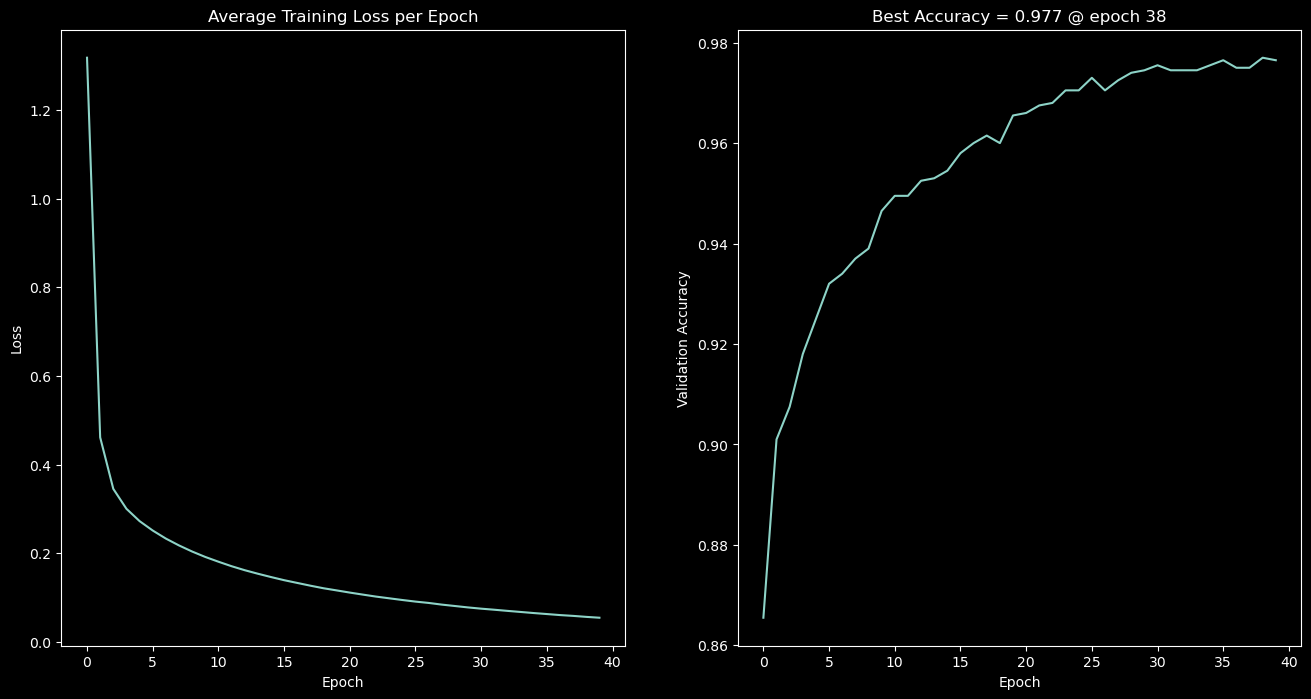

In [19]:
# Training hyperparameters.
device = 'cpu'
lr = 0.0001
epochs = 40

# Instantiate our model and optimizer.
model_mlp = MLP().to(device)
optimizer = torch.optim.Adam(model_mlp.parameters(), lr=lr)

# Our outer training loop, collect loss on train and accuracy on validation.
losses_and_accs = []
for epoch in range(epochs):
    loss = train_epoch(model_mlp, dl_train, optimizer, epoch, device=device)
    (val_acc, _) = evaluate_model(model_mlp, dl_val, device=device)
    losses_and_accs.append((loss, val_acc))
    
# And finally plot the curves.
plot_validation_curves(losses_and_accs)
print(f'Accuracy report on TEST\n: {evaluate_model(model_mlp, dl_test, device=device)[1]}')

## A CNN for MNIST Classification

OK, we have a (simple) MLP baseline for comparison. Let's implement a simple CNN to classify digits and see if we can beat the MLP. 

In [20]:
# A simply Convolutional Neural Network with two convolutional layers followed by maxpools.
# The final convolutional layer is fed into two fully-connected layers followed by the
# final output logits.
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, (5, 5))
        self.conv2 = nn.Conv2d(32, 32, (5, 5))
        self.fc1 = nn.Linear(4*4*32, 64)
        self.fc2 = nn.Linear(64, 64)
        self.output = nn.Linear(64, 10)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2, 2)
        
    def forward(self, xs):
        x = self.maxpool(self.relu(self.conv1(xs)))
        x = self.maxpool(self.relu(self.conv2(x)))
        x = x.view(len(xs), -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.output(x)
        return x

In [21]:
# Training hyperparameters.
device = 'cpu'
lr = 0.0001
epochs = 40

model_cnn = CNN().to(device)
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=lr)

# Our outer training loop, collect loss on train and accuracy on validation.
losses_and_accs = []
for epoch in range(epochs):
    loss = train_epoch(model_cnn, dl_train, optimizer, epoch, device=device)
    (val_acc, _) = evaluate_model(model_cnn, dl_val, device=device)
    losses_and_accs.append((loss, val_acc))
    
# And finally plot the curves.
plot_validation_curves(losses_and_accs)
print(f'Accuracy report on TEST\n: {evaluate_model(model_cnn, dl_test, device=device)[1]}')

Training epoch 0:  74%|███████▍  | 168/227 [00:12<00:04, 13.38it/s]


KeyboardInterrupt: 

## Comparing the two models

Finally, let's have a look at the difference in number of parameters for these two models.

In [ ]:
print(f'MLP: {count_parameters(model_mlp)} trainable parameters.')
print(f'CNN: {count_parameters(model_cnn)} trainable parameters.')